# Differential voltage analysis implementation
- This notebook is used to demonstrate the differential voltage analysis used in the paper.
- The fitting results for the entire dataset is saved in data/electrode_info_04152024.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy 
import sys 
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)
from DVF_functions import *

### Data loading  

In [4]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '..')
pe = pd.read_csv(os.path.join(data_dir, 'data/dvf_data/pe_cycle_1.csv'))
ne = pd.read_csv(os.path.join(data_dir,'data/dvf_data/ne_cycle_020224.csv'))

### Prepare the half/full cell data

In [8]:
window = 9
df_pe = smooth_pe(pe, window)
df_ne = smooth_ne(ne, window)

In [6]:
df_full_169 = process_full_test(os.path.join(data_dir, 'data/dvf_data/full_C_20_169.csv'))
df_full_106 = process_full_test(os.path.join(data_dir, 'data/dvf_data/full_C_20_106.csv'))

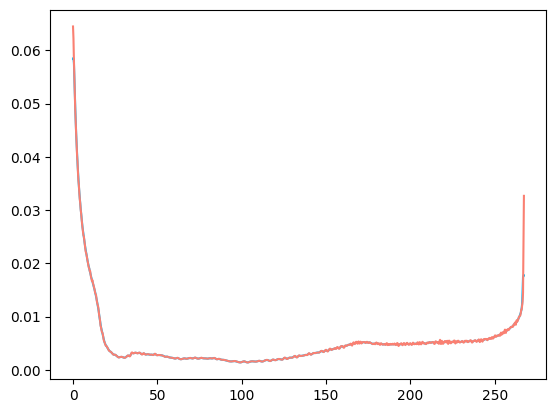

In [7]:
df = df_full_169
dvdq = np.divide(np.gradient(df['Voltage_sm']), np.gradient(df['Q']))
plt.plot(df['Q'], dvdq, color="deepskyblue") 
dvdq = np.divide(np.gradient(df['Voltage_aligned']), np.gradient(df['Q']))
plt.plot(df['Q'], dvdq, color="salmon") 

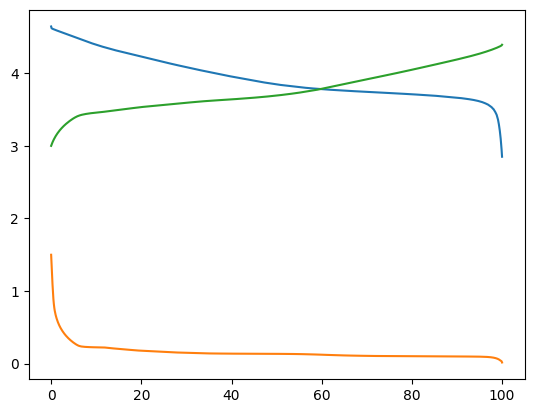

In [9]:
plt.plot(df_pe['SOC_aligned'], df_pe['Voltage_aligned'])
plt.plot(df_ne['SOC_aligned'], df_ne['Voltage_aligned'])
plt.plot(df_full_169['Q']*100/df_full_169['Q'].max(), df_full_169.Voltage_aligned)

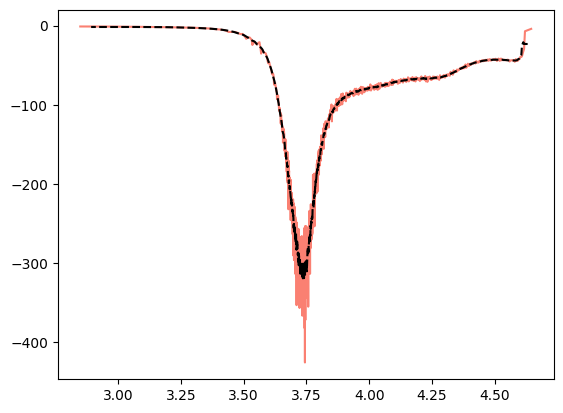

In [10]:
plot_dqdv(df_pe, '-', 'salmon', 'Voltage_aligned')
plot_dqdv(df_pe, '--', 'k', 'Voltage_sm')

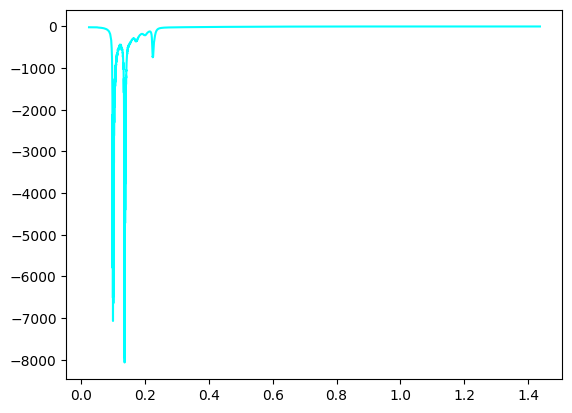

In [11]:
plot_dqdv(df_ne, '-', 'cyan', 'Voltage_sm')
# plot_dqdv(df_ne, '-', 'b', 'Voltage_aligned')

(0.0, 0.03)

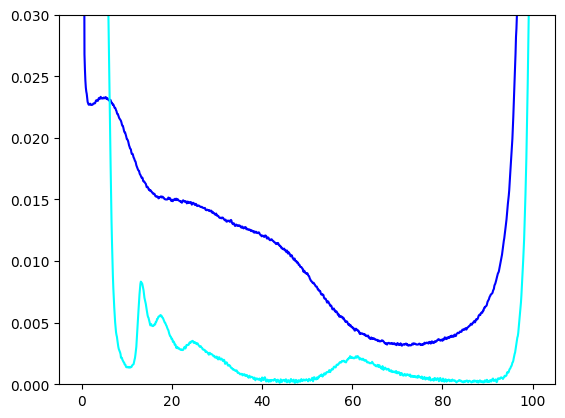

In [12]:
fig, ax = plt.subplots()
plot_dvdq_ele(df_pe, '-', 'b', 'Voltage_sm', ax)
plot_dvdq_ele(df_ne, '-', 'cyan', 'Voltage_sm', ax)
plt.ylim([0, 0.03])

In [13]:
voltage = 'Voltage_sm' 
bounds = [(200,  299), (200, 300), (0, 120), (0, 120), (0, 120)]
full_cell = df_full_169
res_169 =scipy.optimize.shgo(simulation_error, bounds, args=(df_pe, df_ne, df_full_169, voltage))
res_169

 message: Optimization terminated successfully.
 success: True
     fun: 0.0024542469886520805
    funl: [ 2.454e-03]
       x: [ 2.990e+02  2.957e+02  1.531e+00  9.716e+01  3.334e+00]
      xl: [[ 2.990e+02  2.957e+02  1.531e+00  9.716e+01  3.334e+00]]
     nit: 1
    nfev: 523
   nlfev: 490
   nljev: 80
   nlhev: 0

In [14]:
voltage = 'Voltage_sm' 
bounds = [(200,  400), (200, 400), (0, 120), (0, 120), (0, 120)]
full_cell = df_full_106
res_106 =scipy.optimize.shgo(simulation_error, bounds, args=(df_pe, df_ne, df_full_106, voltage))
res_106

 message: Optimization terminated successfully.
 success: True
     fun: 0.0032893966297513617
    funl: [ 3.289e-03]
       x: [ 3.069e+02  2.923e+02  1.042e+00  9.314e+01  1.880e+00]
      xl: [[ 3.069e+02  2.923e+02  1.042e+00  9.314e+01  1.880e+00]]
     nit: 1
    nfev: 477
   nlfev: 444
   nljev: 73
   nlhev: 0

### Functions to make plots for the paper 

In [20]:
def process_fitting_results_vq(res, full_cell, df_ne, df_pe, plot, axs, c, i):
    
    x = res.x
    Q_ne = x[0]
    Q_pe = x[1]
    SOC_ne_0 = x[2]
    SOC_pe_0 = x[3]
    Q_ex = x[4]

    SOC_pe = df_pe['SOC_aligned']
    SOC_ne = df_ne['SOC_aligned']
    pe_voltage_smoothed = df_pe[voltage]
    ne_voltage_smoothed = df_ne[voltage]

    Q = full_cell.Q
    V_oc = full_cell['Voltage_sm']

    pe_input = SOC_pe_0 - Q/Q_pe*100
    ne_input = SOC_ne_0 + Q/Q_ne*100

    f_pe = interpolate.interp1d(SOC_pe, pe_voltage_smoothed, assume_sorted = False, fill_value = 'extrapolate')
    f_ne = interpolate.interp1d(SOC_ne, ne_voltage_smoothed, assume_sorted = False, fill_value = 'extrapolate')

    V_oc_simu = f_pe(pe_input) - f_ne(ne_input)
    error = np.sqrt(np.square(V_oc_simu - V_oc).sum()/len(V_oc))
    
    SOC_ne_100 = SOC_ne_0 + (Q.max()+Q_ex)/Q_ne*100
    SOC_pe_100 = SOC_pe_0 - (Q.max()+Q_ex)/Q_pe*100

    Q_li = SOC_pe_0/100*Q_pe + SOC_ne_0/100*Q_ne
    
    if plot:
        
        dvdq_fc = np.divide(np.gradient(V_oc),np.gradient(Q))
        Q_new = np.linspace(0, Q.max()+Q_ex, 1001)
        V_oc_simu = f_pe(SOC_pe_0 - Q_new/Q_pe*100) - f_ne(SOC_ne_0 + Q_new/Q_ne*100)
        dvdq_fc_sim = np.divide(np.gradient(V_oc_simu),np.gradient(Q_new))

        dqdv_fc = np.divide(np.gradient(Q),np.gradient(full_cell['Voltage_sm']))
        dqdv_fc_sim = np.divide(np.gradient(Q_new),np.gradient(abs(V_oc_simu)))
        
         #dV/dQ 
        axs[i].plot(Q, dvdq_fc, label = 'Real', color = 'grey')
        axs[i].plot(Q_new, dvdq_fc_sim, label = 'Fitted', color = 'skyblue')
        axs[i].legend(loc = 'best')
        axs[i].set_ylabel('dVdQ')
        axs[i].set_ylim([0, 0.008])
        axs[i].set_xlabel('Capacity (mAh)')
        
        #dQ/dV
        axs[1+i].plot(V_oc, dqdv_fc, label = 'Real', color = 'grey')
        axs[1+i].plot(V_oc_simu, dqdv_fc_sim, label = 'Fitted', color = 'skyblue')
        axs[1+i].legend(loc = 'best')
        axs[1+i].set_ylabel('dQdV')
        axs[1+i].set_xlabel('Voltage (V)')
        
        # V_Q 
        axs[2+i].plot(Q, V_oc, label = 'Real', color = 'grey')
        axs[2+i].plot(Q_new, V_oc_simu, label = 'Fitted', color = 'skyblue')
        axs[2+i].legend(loc = 'best')
        axs[2+i].set_ylabel('Voltage/V')
        axs[2+i].set_xlabel('Capacity (mAh)')
           
#         #V_Q 
#         if ne: 
#             x = ne_input
#             axs.set_xlabel('Anode SOC (%)', fontsize = 8)
#             soc_return = SOC_ne_100
#         else:
#             x = pe_input
#             axs.set_xlabel('Cathode SOC (%)', fontsize = 8)
#             soc_return = SOC_pe_0
        
#         y = V_oc
#         axs.plot(x, y, c = c)
#         axs.set_ylabel('Voltage (V)', fontsize = 8)
#         f = interpolate.interp1d(x, y, fill_value = 'extrapolate')
        
#         return soc_return, f
        
#         #simulated electrodes and full cell curves
#         y_vec = np.linspace(0, 100, 1000)
#         x_vec = np.linspace(0, 100, 1000)
#         qpos = Q_pe*(SOC_pe_0 - y_vec)/100
#         vpos = f_pe(y_vec)
#         axs.plot(qpos, vpos, color = 'royalblue', label = 'PE')
# #         axs.plot(Q, V_oc, label = 'Real', color = 'grey')
# #         axs.plot(Q, f_pe(pe_input) - f_ne(ne_input), label = 'Fitted', color = 'grey', linestyle = '--')
#         qneg = Q_ne*(x_vec - SOC_ne_0)/100
#         vneg = f_ne(x_vec)
#         axs.plot(qneg, vneg, color = 'salmon', label = 'NE')
#         # plot_dvdq(v, q, 'b', axs[3], 'PE')
#         # q = ne_input*Q_ne/100
#         # v = f_ne(ne_input)
#         # plot_dvdq(v, q, 'cyan', axs[3], 'NE')
#         axs.set_ylabel('Voltage (V)', fontsize = 8, labelpad = 6)
#         axs.set_xlabel('Q (mAh)', fontsize = 8, labelpad = 6)
#         axs.set_xlim([-30, 300])
#         axs.vlines(x=[0, np.max(Q)], ymin=0, ymax=5,
#               color=[0.4, 0.4, 0.4],
#               linestyle=':') 

In [21]:
def process_fitting_results_electrode(res, full_cell, df_ne, df_pe, plot, axs, c, i):
    
    x = res.x
    Q_ne = x[0]
    Q_pe = x[1]
    SOC_ne_0 = x[2]
    SOC_pe_0 = x[3]
    Q_ex = x[4]

    SOC_pe = df_pe['SOC_aligned']
    SOC_ne = df_ne['SOC_aligned']
    pe_voltage_smoothed = df_pe[voltage]
    ne_voltage_smoothed = df_ne[voltage]

    Q = full_cell.Q
    V_oc = full_cell['Voltage_sm']

    pe_input = SOC_pe_0 - Q/Q_pe*100
    ne_input = SOC_ne_0 + Q/Q_ne*100

    f_pe = interpolate.interp1d(SOC_pe, pe_voltage_smoothed, assume_sorted = False, fill_value = 'extrapolate')
    f_ne = interpolate.interp1d(SOC_ne, ne_voltage_smoothed, assume_sorted = False, fill_value = 'extrapolate')

    V_oc_simu = f_pe(pe_input) - f_ne(ne_input)
    error = np.sqrt(np.square(V_oc_simu - V_oc).sum()/len(V_oc))
    
    SOC_ne_100 = SOC_ne_0 + (Q.max()+Q_ex)/Q_ne*100
    SOC_pe_100 = SOC_pe_0 - (Q.max()+Q_ex)/Q_pe*100

    Q_li = SOC_pe_0/100*Q_pe + SOC_ne_0/100*Q_ne
    
    if plot:
        
        dvdq_fc = np.divide(np.gradient(V_oc),np.gradient(Q))
        Q_new = np.linspace(0, Q.max()+Q_ex, 1001)
        V_oc_simu = f_pe(SOC_pe_0 - Q_new/Q_pe*100) - f_ne(SOC_ne_0 + Q_new/Q_ne*100)
        dvdq_fc_sim = np.divide(np.gradient(V_oc_simu),np.gradient(Q_new))

        dqdv_fc = np.divide(np.gradient(Q),np.gradient(full_cell['Voltage_sm']))
        dqdv_fc_sim = np.divide(np.gradient(Q_new),np.gradient(abs(V_oc_simu)))
        
        #         simulated electrodes and full cell curves
        y_vec = np.linspace(0, 100, 1000)
        x_vec = np.linspace(0, 100, 1000)
        qpos = Q_pe*(SOC_pe_0 - y_vec)/100
        vpos = f_pe(y_vec)
        axs[i].plot(qpos, vpos, color = 'skyblue', label = 'PE')
#         axs[i].plot(Q, V_oc, label = 'Real', color = 'grey')
#         axs[i].plot(Q, f_pe(pe_input) - f_ne(ne_input), label = 'Fitted', color = 'grey', linestyle = '--')
        qneg = Q_ne*(x_vec - SOC_ne_0)/100
        vneg = f_ne(x_vec)
        axs[i].plot(qneg, vneg, color = 'royalblue', label = 'NE')
        # plot_dvdq(v, q, 'b', axs[3], 'PE')
        # q = ne_input*Q_ne/100
        # v = f_ne(ne_input)
        # plot_dvdq(v, q, 'cyan', axs[3], 'NE')
        axs[i].legend(loc = 'center', fontsize = 6)
        axs[i].set_ylabel('Voltage (V)', fontsize = 8)
        axs[i].set_xlabel('Q (mAh)', fontsize = 8)
        axs[i].set_xlim([-25, 300])
        axs[i].vlines(x=[0, np.max(Q)], ymin=0, ymax=5,
              color=[0.4, 0.4, 0.4],
              linestyle=':')   
        
#         #dqdv plot for individual electrodes
#         q = (100 - pe_input)*Q_pe/100
#         v = f_pe(pe_input)
#         plot_dvdq(vpos, qpos, 'skyblue', axs[i+1], 'PE')
#         q = ne_input*Q_ne/100
#         v = f_ne(ne_input)
#         plot_dvdq(vneg, qneg, 'royalblue', axs[i+1], 'NE')
        
#         axs[i+1].plot(Q, dvdq_fc, label = 'Real', color = 'grey')
# #         axs[i+1].plot(Q_new, dvdq_fc_sim, label = 'Fitted', color = 'grey', ls = '--')
        
#         axs[i+1].axvline(x = 0, color = 'cyan', ls = '--')
        
#         axs[i+1].legend(loc = 'best', fontsize = 6)
#         axs[i+1].set_ylabel('dVdQ')
#         axs[i+1].set_xlabel('Q (mAh)')
#         axs[i+1].set_ylim([0, 0.008])
#         axs[i+1].set_xlim([-25, 300])
        
#         #V_Q 
#         if ne: 
#             x = ne_input
#             axs.set_xlabel('Anode SOC (%)', fontsize = 8)
#             soc_return = SOC_ne_100
#         else:
#             x = pe_input
#             axs.set_xlabel('Cathode SOC (%)', fontsize = 8)
#             soc_return = SOC_pe_0
        
#         y = V_oc
#         axs.plot(x, y, c = c)
#         axs.set_ylabel('Voltage (V)', fontsize = 8)
#         f = interpolate.interp1d(x, y, fill_value = 'extrapolate')
        
#         return soc_return, f
        
#         #simulated electrodes and full cell curves
#         y_vec = np.linspace(0, 100, 1000)
#         x_vec = np.linspace(0, 100, 1000)
#         qpos = Q_pe*(SOC_pe_0 - y_vec)/100
#         vpos = f_pe(y_vec)
#         axs.plot(qpos, vpos, color = 'royalblue', label = 'PE')
# #         axs.plot(Q, V_oc, label = 'Real', color = 'grey')
# #         axs.plot(Q, f_pe(pe_input) - f_ne(ne_input), label = 'Fitted', color = 'grey', linestyle = '--')
#         qneg = Q_ne*(x_vec - SOC_ne_0)/100
#         vneg = f_ne(x_vec)
#         axs.plot(qneg, vneg, color = 'salmon', label = 'NE')
#         # plot_dvdq(v, q, 'b', axs[3], 'PE')
#         # q = ne_input*Q_ne/100
#         # v = f_ne(ne_input)
#         # plot_dvdq(v, q, 'cyan', axs[3], 'NE')
#         axs.set_ylabel('Voltage (V)', fontsize = 8, labelpad = 6)
#         axs.set_xlabel('Q (mAh)', fontsize = 8, labelpad = 6)
#         axs.set_xlim([-30, 300])
#         axs.vlines(x=[0, np.max(Q)], ymin=0, ymax=5,
#               color=[0.4, 0.4, 0.4],
#               linestyle=':') 

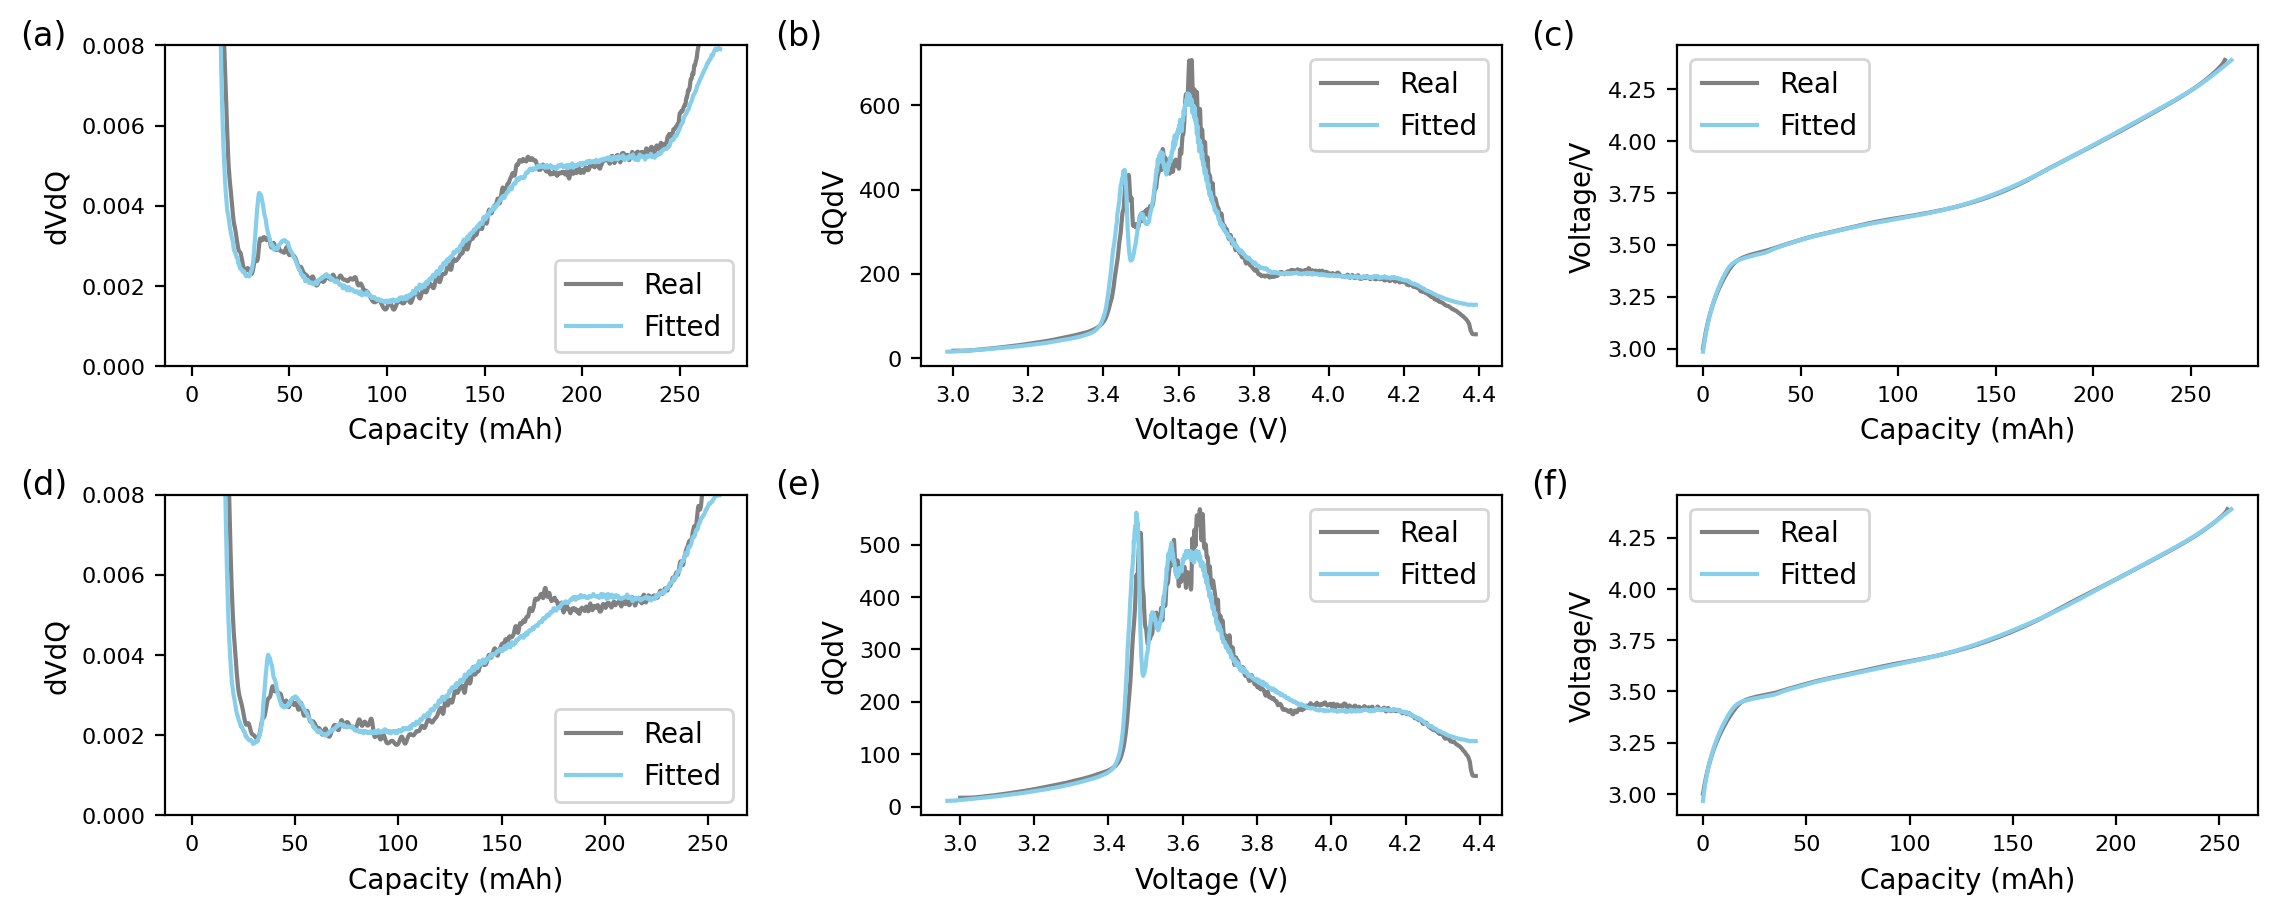

In [22]:
num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*4.5, num_rows*2.5), facecolor='w', edgecolor='k', dpi = 200)
fig.subplots_adjust(hspace = .4, wspace=.3)
axs = axs.ravel()
c = 'grey'
process_fitting_results_vq(res_169, df_full_169, df_ne, df_pe, 1, axs, c, 0)
c = 'royalblue'
process_fitting_results_vq(res_106, df_full_106, df_ne, df_pe, 1, axs, c, 3)
for ax in axs:
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)
    
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(axs):
    ax.text(-0.25, 1.0, labels[i], transform=ax.transAxes, size=12)
# plt.savefig('SI_fitting_results.pdf', transparent = True, bbox_inches='tight')

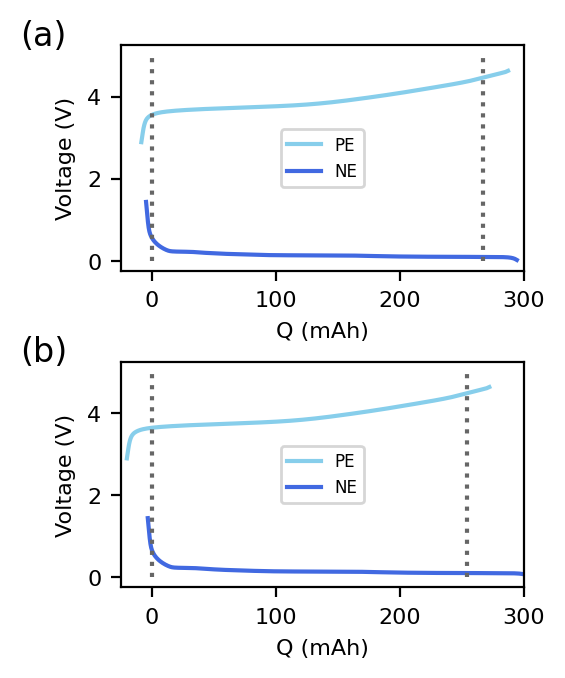

In [23]:
num_rows = 2
num_cols = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.8/3*num_cols, 1.76*num_rows), dpi = 200)
fig.subplots_adjust(hspace = .4, wspace=.3)
# axs = axs.ravel()
c = 'grey'
process_fitting_results_electrode(res_169, df_full_169, df_ne, df_pe, 1, axs, c, 0)
c = 'royalblue'
process_fitting_results_electrode(res_106, df_full_106, df_ne, df_pe, 1, axs, c, 1)
for ax in axs:
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)
    
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(axs):
    ax.text(-0.25, 1.0, labels[i], transform=ax.transAxes, size=12)
# plt.savefig('4_ab.svg', transparent = True, bbox_inches='tight')

### Functions to visualize the fit 

(0.0042991226328450175,
 92.06432306386486,
 5.62478396498976,
 267.36123729999997,
 291.90561172283464)

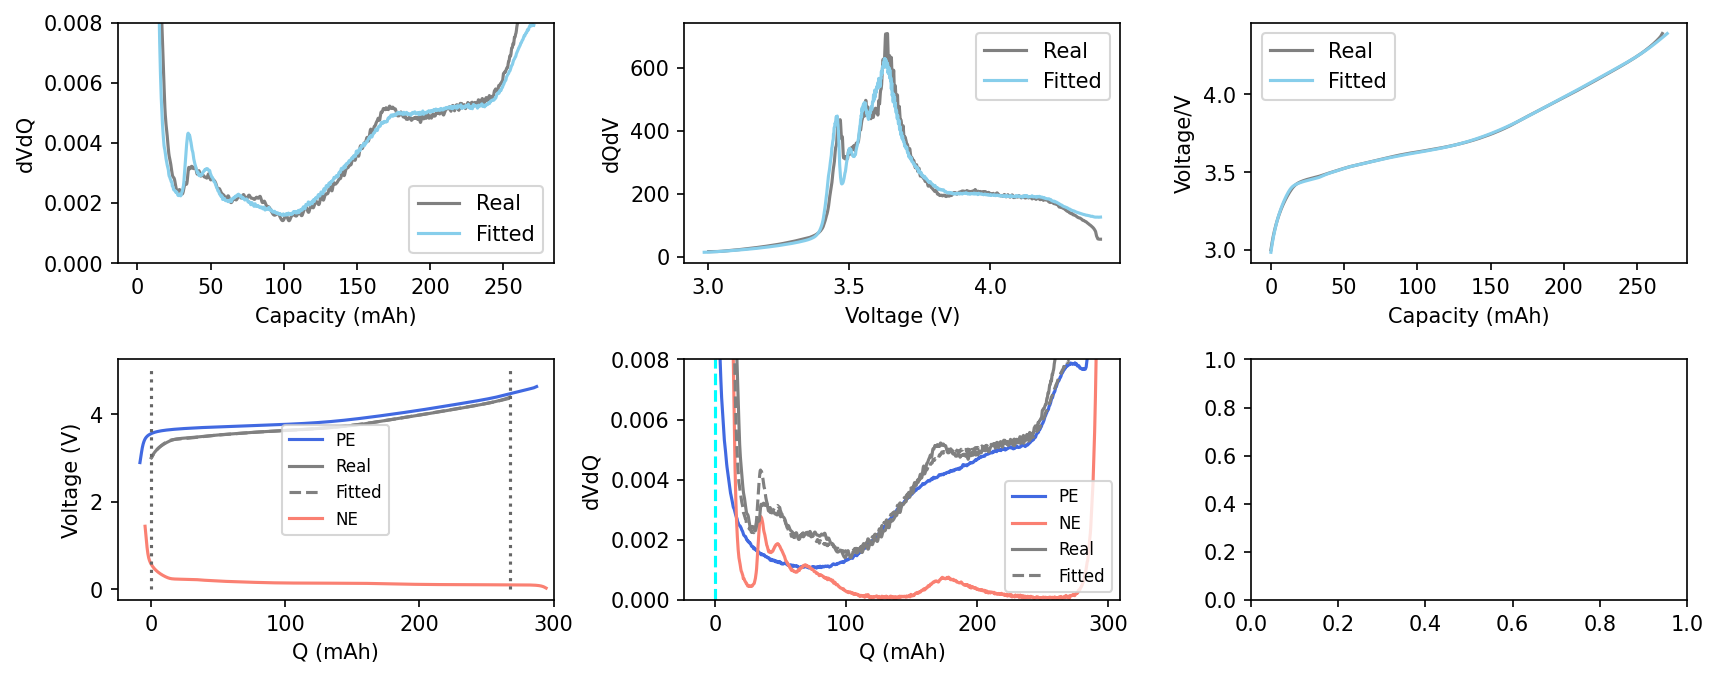

In [17]:
process_fitting_results(res_169, df_full_169, df_ne, df_pe, 1, voltage)
# plt.savefig('fitting_results_slow.pdf', transparent = True, bbox_inches='tight')

(0.005222905859032041,
 84.41327277303333,
 5.597986830716522,
 253.98714700000002,
 275.42713587801)

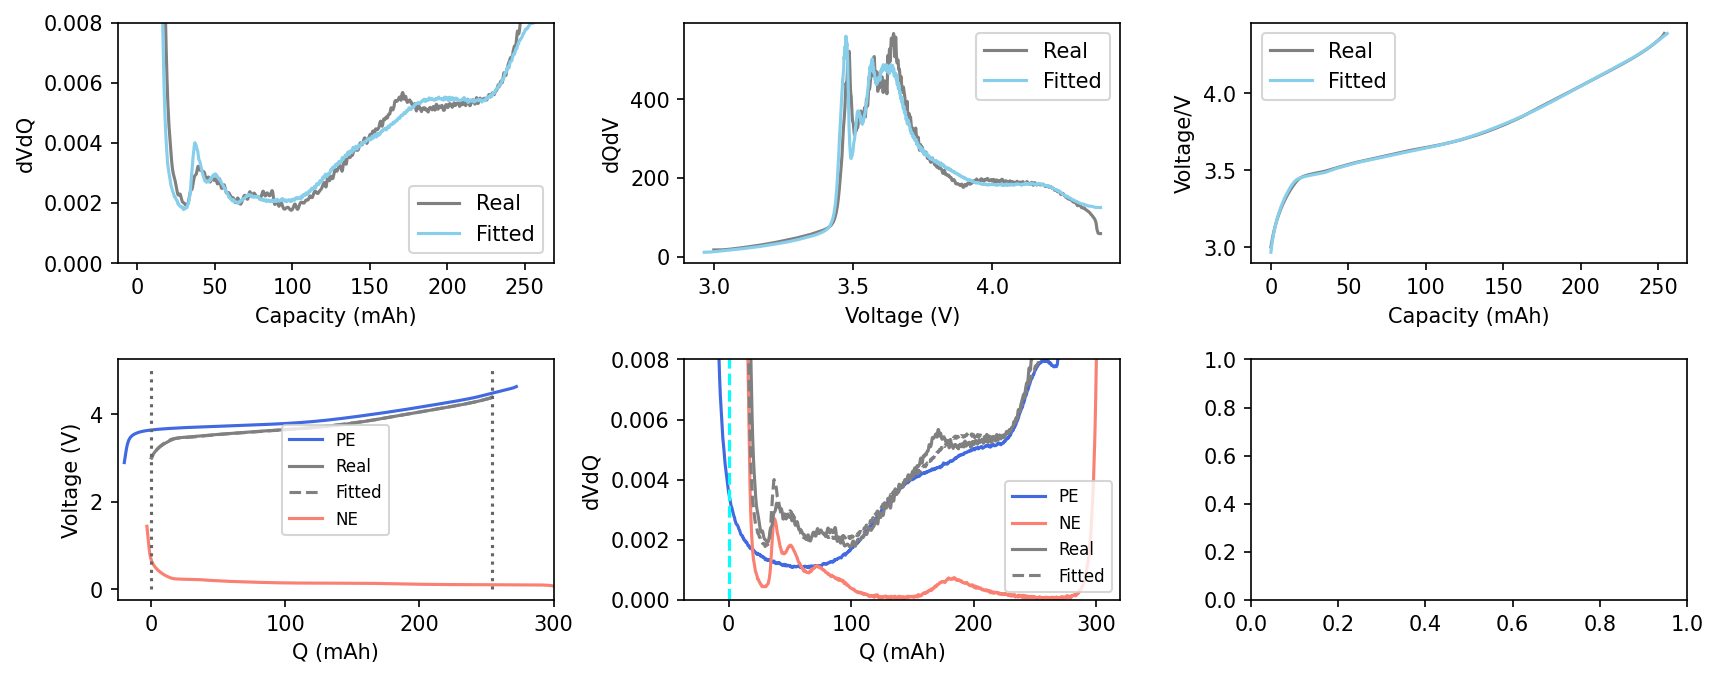

In [18]:
process_fitting_results(res_106, df_full_106, df_ne, df_pe, 1, voltage)
# plt.savefig('fitting_results_fast.pdf', transparent = True, bbox_inches='tight')